In [1]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [2]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.csv', index_col = False)

In [4]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [5]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [6]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [7]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [8]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [9]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [10]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [11]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [12]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [13]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [14]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [15]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [16]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

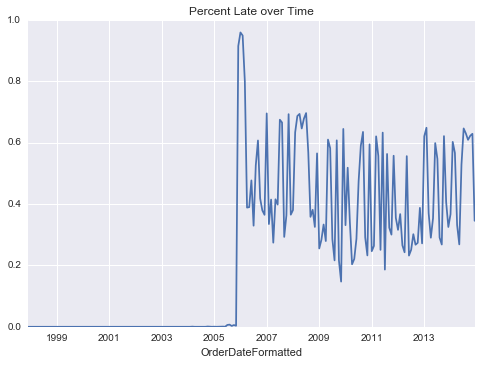

In [17]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [18]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [83]:
USMTO_WHOLE.describe()

,AAID,NAICSID,Units,TotalSale,IsSubmitted,SubCategory,MachineCode,EntryMonth,EntryYear,Close,IP,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
count,392068.000000,392068.000000,392068.000000,3.920680e+05,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000
mean,101567.163523,451.643654,0.969559,1.511589e+05,0.999612,26.011322,3568.717931,6.866054,2010.319011,1424.766320,100.536678,14.907945,0.440000,0.303307,0.213754,0.031885
std,5267.014327,280.468735,0.234727,2.890960e+05,0.019686,9.751844,384.827128,3.410505,2.604354,282.721568,4.419017,92.569530,0.496388,0.459687,0.409955,0.175694
min,123.000000,1.000000,-1.000000,-9.861252e+06,0.000000,1.000000,3541.205000,1.000000,2006.000000,735.090027,87.412500,-39.000000,0.000000,0.000000,0.000000,0.000000
25%,100132.000000,209.000000,1.000000,4.598594e+04,1.000000,23.000000,3541.540000,4.000000,2008.000000,1267.380005,97.747400,-4.000000,0.000000,0.000000,0.000000,0.000000
50%,100333.000000,248.000000,1.000000,8.190807e+04,1.000000,23.000000,3541.704000,7.000000,2011.000000,1397.910034,101.601600,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100525.000000,749.000000,1.000000,1.650000e+05,1.000000,36.000000,3541.708000,10.000000,2013.000000,1549.380005,104.172000,7.000000,1.000000,1.000000,0.000000,0.000000
max,123556.000000,924.000000,1.000000,4.475133e+07,1.000000,44.000000,9999.999000,12.000000,2014.000000,2067.560059,106.686800,3190.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


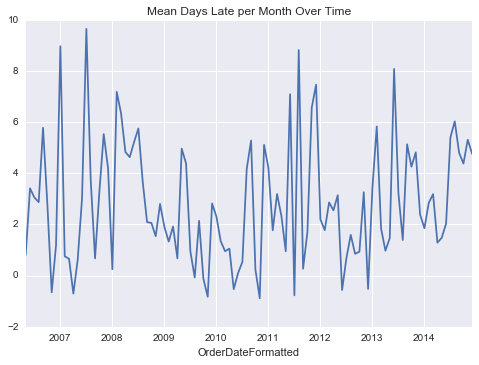

In [21]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [22]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


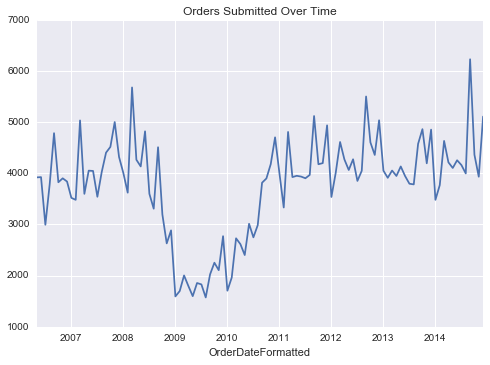

In [23]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

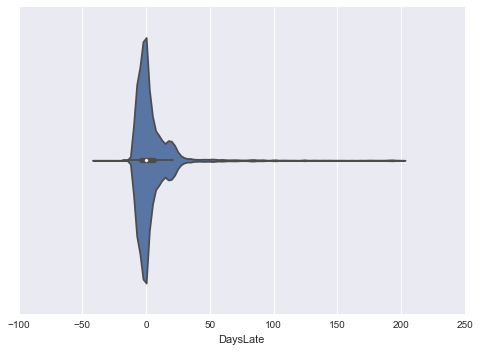

In [24]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [25]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,1.846154e+04,240000.00
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,1.000000e+05,200000.00
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,1.314387e+05,920071.00
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,1.539455e+05,307891.00
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,5.797109e+04,637682.00
5,100005,2006-08-01,15.0,1,1,1,0,1303.819946,102.8357,1,6.599400e+04,65994.00
6,100005,2006-10-01,3.0,1,0,0,0,1377.939941,102.6297,1,1.063480e+05,106348.00
7,100005,2006-11-01,-3.0,0,0,0,0,1400.630005,102.5390,15,1.291431e+05,1937146.00
8,100005,2006-12-01,-7.0,0,0,0,0,1418.300049,103.6229,1,6.636000e+04,66360.00
9,100005,2007-01-01,-9.0,0,0,0,0,1438.239990,103.1171,4,1.997450e+04,79898.01


In [26]:
#gets rid of all observations that are backfills
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 90]


In [84]:
#temporary fill in for adding in last three months late/sales until python script is written

AAID_BY_MONTH_NO_BACKFILL.to_csv('../Data/AAID By Month')
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/AAID By Month Edited.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)


In [86]:
AAID_BY_MONTH_NO_BACKFILL.dtypes

AAID                      int64
OrderDateFormatted       object
DaysLate                  int64
IsEmailOne                int64
IsEmailTwo                int64
IsCall                    int64
IsBackfill                int64
Close                   float64
Units                     int64
TotalSaleAvg            float64
TotalSale               float64
Three_MMA_Late          float64
Three_MMA_SalesTrend    float64
DaysLateLastThree       float64
TotalSaleLastThree      float64
DaysLateLast            float64
IP                      float64
UnitsLast               float64
TotalSaleAvgLast        float64
IsCallLast              float64
dtype: object

In [29]:
#create column "Three MMA Late" - which models the average of the past three month's lateness for each company

#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_Late'] = AAID_BY_MONTH_NO_BACKFILL.DaysLate.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_Late'].mean().plot(kind = 'line')


In [30]:
#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_SalesTrend'] = AAID_BY_MONTH_NO_BACKFILL.TotalSale.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_SalesTrend'].sum().plot(kind = 'line')

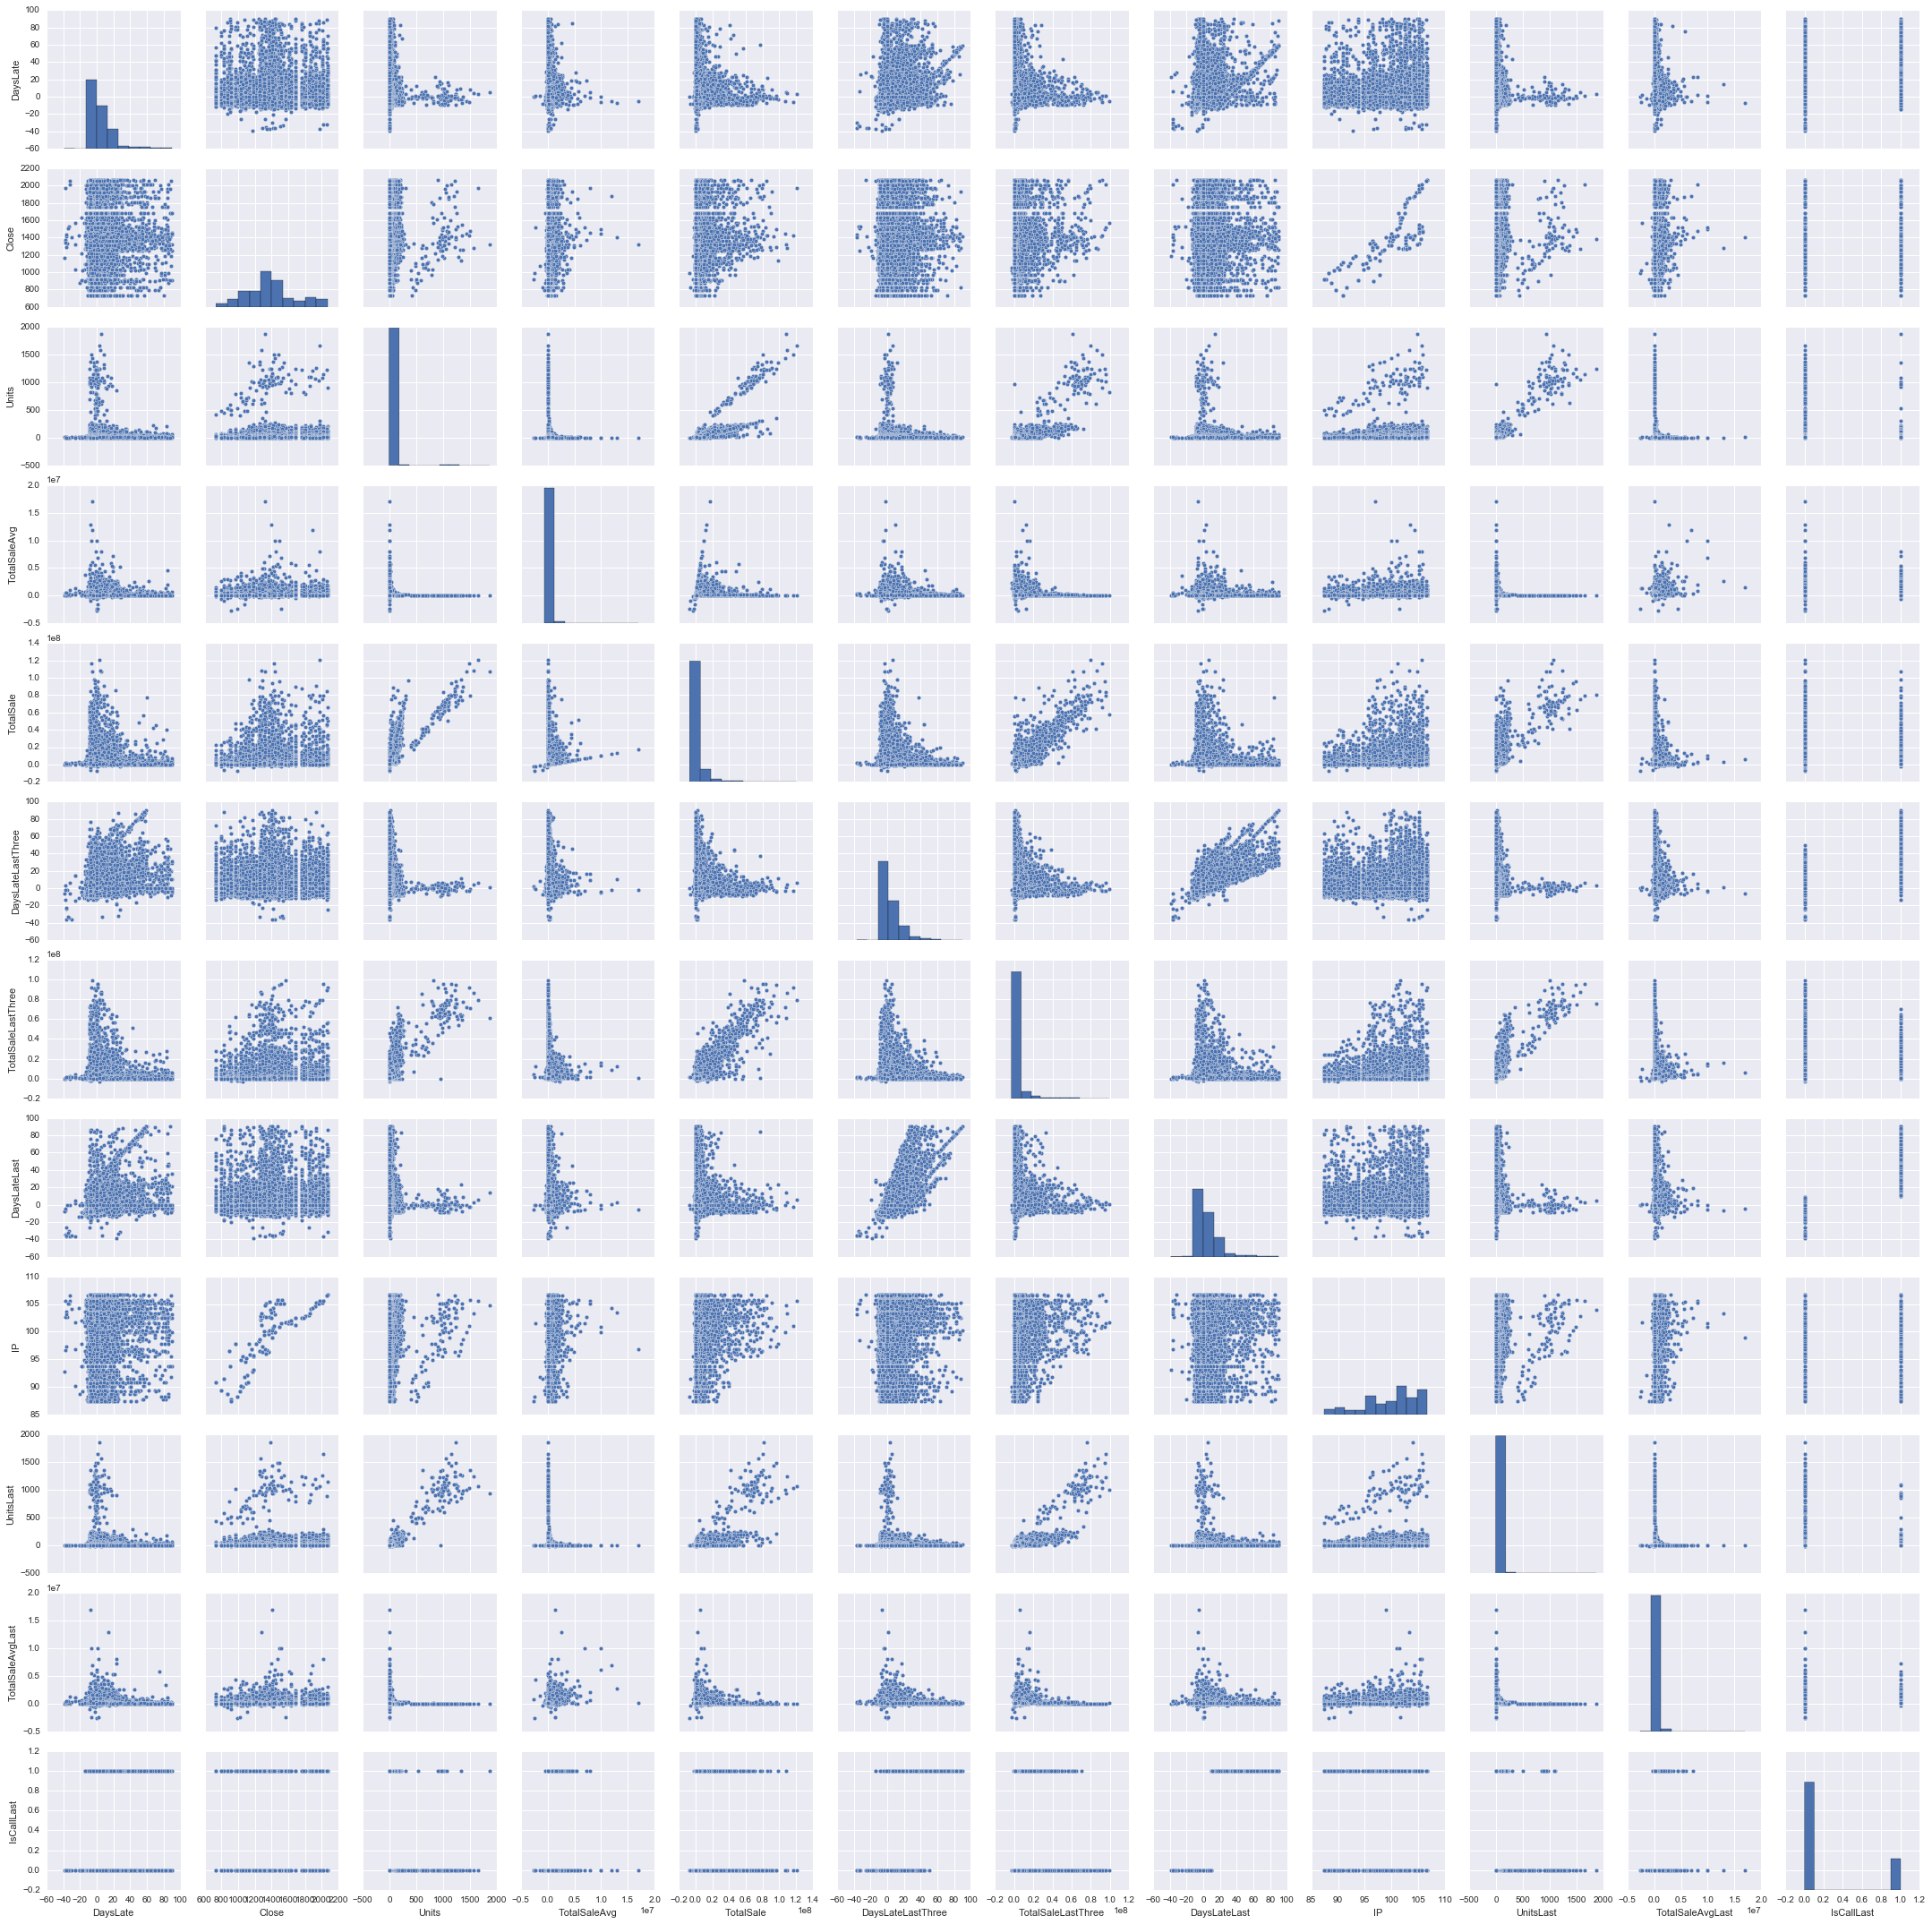

In [87]:
#scatter matrix identifying key features - target excluded

PAIRPLOT = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT = PAIRPLOT.drop('AAID', axis = 1)
PAIRPLOT = PAIRPLOT.drop('OrderDateFormatted', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsEmailOne', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsEmailTwo', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsCall', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsBackfill', axis = 1)
PAIRPLOT = PAIRPLOT.drop('Three_MMA_Late', axis = 1)
PAIRPLOT = PAIRPLOT.drop('Three_MMA_SalesTrend', axis = 1)

sns.pairplot(PAIRPLOT)

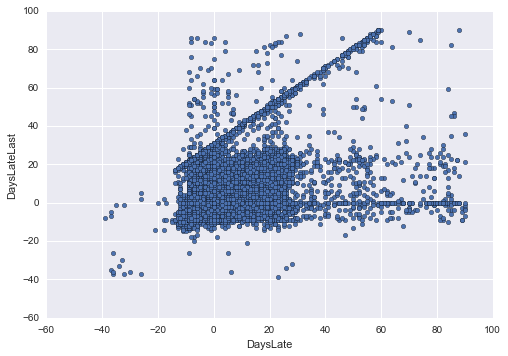

In [90]:
#DaysLate Last vs Days Late (suspicious line - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

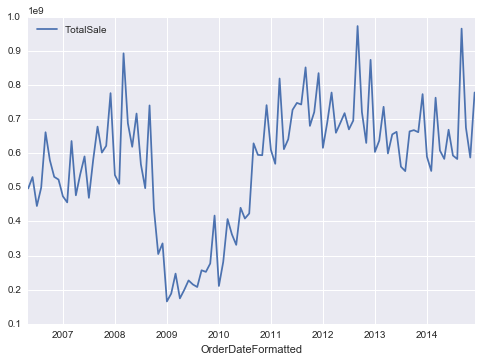

In [54]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

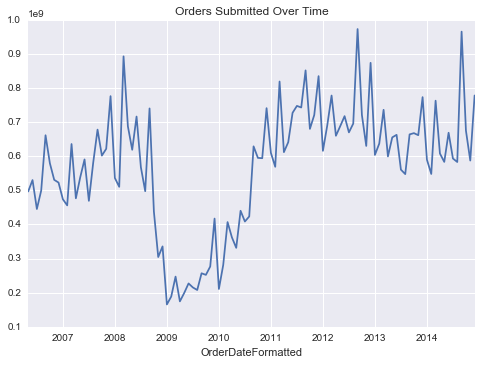

In [55]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

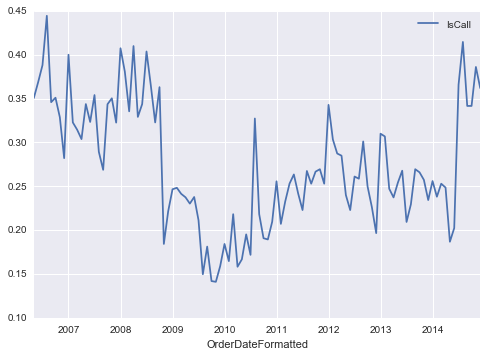

In [56]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

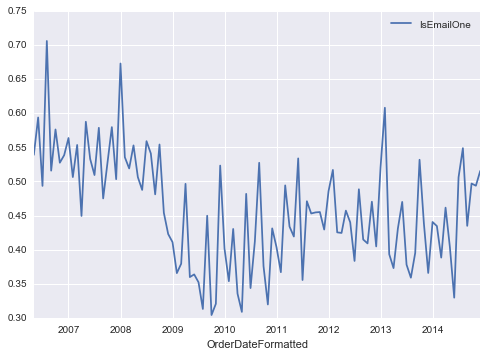

In [57]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

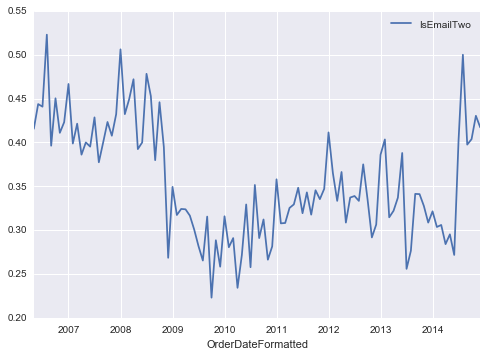

In [58]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

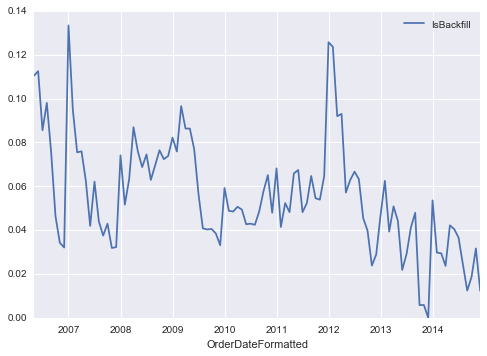

In [59]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [114]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)



corr2 = PAIRPLOT2.corr(method = 'pearson')

In [115]:
PAIRPLOT2.columns

Index(['IsCall', 'Close', 'Three_MMA_Late', 'Three_MMA_SalesTrend',
       'DaysLateLastThree', 'TotalSaleLastThree', 'DaysLateLast', 'IP',
       'UnitsLast', 'TotalSaleAvgLast', 'IsCallLast'],
      dtype='object')

In [93]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [94]:
#Correlations between Attributes

corr = PAIRPLOT.corr(method = 'pearson')

In [95]:
#Skew of Attributes

PAIRPLOT.skew()

DaysLate               2.466051
Close                  0.369165
Units                 11.854637
TotalSaleAvg          12.365677
TotalSale              6.010543
DaysLateLastThree      2.282692
TotalSaleLastThree     5.921180
DaysLateLast           2.516090
IP                    -0.724223
UnitsLast             11.925780
TotalSaleAvgLast      12.234455
IsCallLast             1.313808
dtype: float64

In [116]:
PAIRPLOT2.corr()

,IsCall,Close,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP,UnitsLast,TotalSaleAvgLast,IsCallLast
IsCall,1.000000,0.077764,0.757631,-0.003002,0.468473,-0.008318,0.449449,0.122950,-0.028395,0.030896,0.461439
Close,0.077764,1.000000,0.072659,0.064332,0.055856,0.063488,0.060961,0.789642,0.036185,0.028630,0.068478
Three_MMA_Late,0.757631,0.072659,1.000000,0.002579,0.773360,-0.004209,0.747065,0.124476,-0.020709,0.022627,0.618408
Three_MMA_SalesTrend,-0.003002,0.064332,0.002579,1.000000,-0.003181,0.965752,0.003329,0.083472,0.782593,0.101729,-0.002014
DaysLateLastThree,0.468473,0.055856,0.773360,-0.003181,1.000000,0.000280,0.805167,0.100720,-0.018297,0.026482,0.669605
TotalSaleLastThree,-0.008318,0.063488,-0.004209,0.965752,0.000280,1.000000,0.002877,0.080767,0.788520,0.112716,0.000166
DaysLateLast,0.449449,0.060961,0.747065,0.003329,0.805167,0.002877,1.000000,0.095675,-0.012965,0.023663,0.782168
IP,0.122950,0.789642,0.124476,0.083472,0.100720,0.080767,0.095675,1.000000,0.045953,0.030492,0.108129
UnitsLast,-0.028395,0.036185,-0.020709,0.782593,-0.018297,0.788520,-0.012965,0.045953,1.000000,-0.053644,-0.023003
TotalSaleAvgLast,0.030896,0.028630,0.022627,0.101729,0.026482,0.112716,0.023663,0.030492,-0.053644,1.000000,0.032428


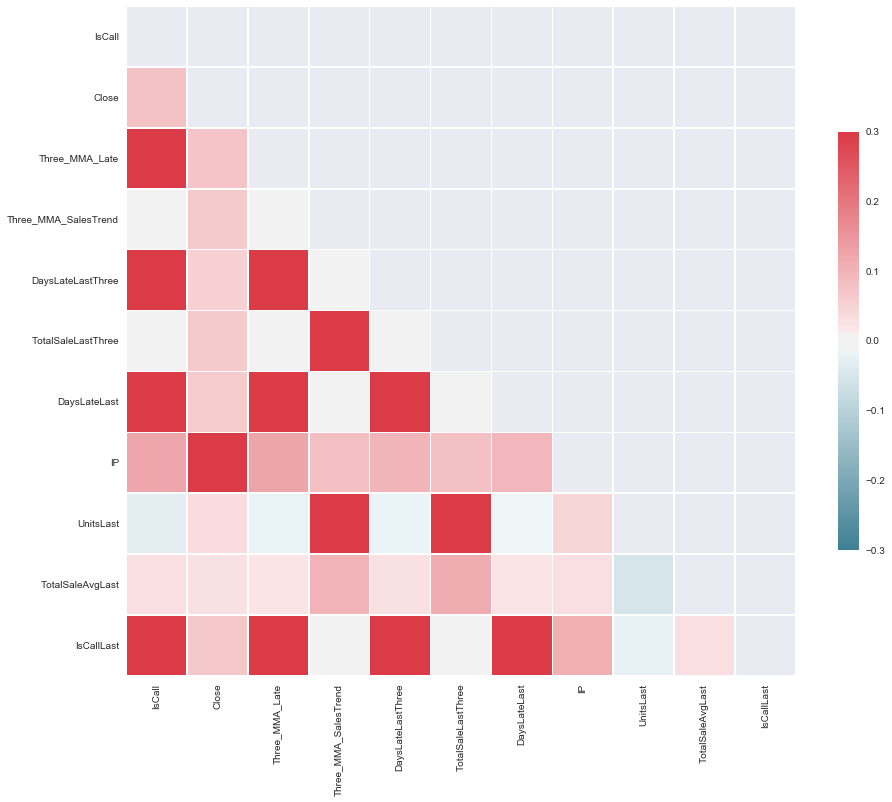

In [117]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


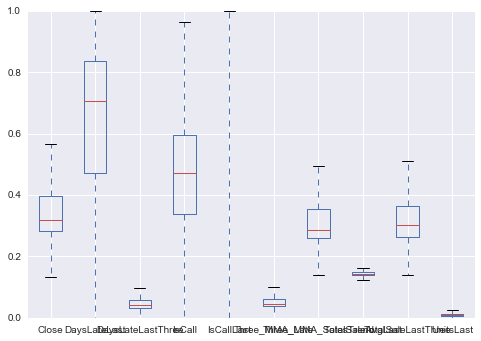

In [118]:
#rescales all data to be between 0 and 1 and readies it for further processing - in progress

import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:12]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

#rescaledX3 = rescaledX.reshape((-1,11))

rescaledX3 = pd.DataFrame({'IsCall':rescaledX[:,0],'Close':rescaledX[:,1],'Three_MMA_Late':rescaledX[:,2],'Three_MMA_SalesTrend':rescaledX[:,3],'DaysLateLastThree':rescaledX[:,4],'TotalSaleLastThree':rescaledX[:,5],'DaysLateLast':rescaledX[:,6],'UnitsLast':rescaledX[:,7],'TotalSaleAvgLast':rescaledX[:,8],'IsCallLast':rescaledX[:,9]})
rescaledX3.plot.box()

In [44]:
#relationship between last month's days late and this month's call

#rescaledX3.plot.scatter('DaysLateLast','IsCall')

In [99]:
#columns which correspond to feature selection output

PAIRPLOT2.columns

Index(['IsCall', 'Close', 'Units', 'TotalSaleAvg', 'TotalSale',
       'Three_MMA_Late', 'Three_MMA_SalesTrend', 'DaysLateLastThree',
       'TotalSaleLastThree', 'DaysLateLast', 'IP', 'UnitsLast',
       'TotalSaleAvgLast', 'IsCallLast'],
      dtype='object')

In [102]:
# Feature Importance with Extra Trees Classifier - Three_MMA_Late, Three_MMA_SalesTrend, DaysLateLast are selected (threshold 0.1)

from sklearn.ensemble import ExtraTreesClassifier

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.02210648  0.02132193  0.0223734   0.02285021  0.53011088  0.02086286
  0.06942858  0.02131216  0.04220789  0.02481492  0.02095377  0.02127965
  0.16037728]


In [103]:
# Feature Extraction with RFE - IP, DaysLateLast, DaysLateLastThree, Three_MMA_Late are selected

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [False False False False  True False  True False  True False False False
  True]
Feature Ranking:  [ 5  4  9 10  1  8  1  7  1  2  3  6  1]


In [104]:
#Feature Extraction with PCA - in progress

from sklearn.decomposition import PCA
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [ 0.96121789  0.03470732  0.00217056  0.00147316]
[[  1.45918166e-06   5.05582347e-06   3.82784599e-03   5.97375050e-01
    6.20601024e-10   5.75230958e-01  -2.60321061e-09   5.58773742e-01
    3.30079285e-09   3.07700707e-08   4.93217378e-06   3.10592355e-03
   -3.95016285e-11]
 [  4.13973047e-07   6.79863362e-07   2.18031571e-02   6.83424320e-01
    7.38280579e-08  -1.09396832e-03  -5.75128469e-08  -7.29591740e-01
    2.86645671e-10  -7.10589216e-09  -4.38446613e-06  -1.22685501e-02
   -6.96377281e-10]
 [  8.10334817e-06   1.88841839e-06  -5.73949094e-03   4.18439494e-01
   -4.96574039e-07  -8.16830753e-01   7.21482957e-08   3.93861399e-01
   -1.01744402e-07  -1.08173536e-07  -4.78634251e-06  -5.03603797e-02
    6.57923752e-09]
 [ -1.45308221e-05   2.67058323e-05  -7.26101518e-01  -8.25690343e-03
   -6.04479055e-07   3.45418306e-02  -7.75210818e-07  -1.79422215e-02
   -7.64090002e-07  -2.57239540e-07   2.55226181e-05  -6.86435245e-01
   -3.18561332e-08]]


In [49]:
#we end up using all features

In [121]:
#train/test algorithm using all 10 features

# Evaluate using a train and a test set
from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
print("Accuracy: ", result*100.0)

Accuracy:  76.3694748772


In [122]:
# Evaluate using Cross Validation using all 10 features

from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LogisticRegression()
results = cross_validation.cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: ", results.mean()*100.0, "      Std Dev: ", results.std()*100.0)

Accuracy:  76.8142144638       Std Dev:  5.37769794048


In [123]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LogisticRegression()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std()*100.0)

Logloss:  -0.557477339718       Std Dev:  6.50014060055


In [124]:
# Cross Validation Classification with Area Under the Curve (Between 0.5 and 1 indicates good model)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LogisticRegression()
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)

AUC:  0.463054587421       Std Dev:  4.32352298318


In [125]:
#classification report

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.76      1.00      0.87      4043
        1.0       0.00      0.00      0.00      1251

avg / total       0.58      0.76      0.66      5294



C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
#APPENDIX AS FOLLOWS: (works in progress)

In [61]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



SyntaxError: invalid syntax (<ipython-input-61-8bd383b2e483>, line 6)

In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE